In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment


2025-03-27 13:39:37.241236: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  3


2025-03-27 13:39:39.952104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-03-27 13:39:43.539523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2025-03-27 13:39:43.540852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2025-03-27 13:39:43.541635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2025-03

In [3]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

3 Physical GPUs, 3 Logical GPUs


2025-03-27 13:39:48.302633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-27 13:39:48.606386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2025-03-27 13:39:48.607752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2025-03-27 13:39:48.609099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Fou

In [4]:
#Reading files into a log
import sys
import logging

nblog = open("nb_id.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [5]:
np.random.seed(42)
tf.random.set_seed(8)


In [6]:
def build_model(p_i):
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "track")
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "tower")
    y = keras.layers.BatchNormalization()(input_1)
    z = keras.layers.BatchNormalization()(input_2)
    cnn = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (5, 5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(3, activation = 'softmax')
    ])
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    x_out = keras.layers.Multiply()([x_1, x_2])
    model = keras.Model(         
    inputs=[input_1, input_2],
    outputs=x_out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [7]:
def build_model_clustering(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [12]:
#Preparing samples
n_samples = 3
os.chdir('/home/manhducnmd/manhducnmd/Delphes-3.5.0')    
sample_1_1_train_track = np.load(f'wboson_region_1_track.npy')
sample_1_1_train_tower = np.load(f'wboson_region_1_tower.npy')
true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                          np.shape(sample_1_1_train_track)[0]).reshape(np.shape(sample_1_1_train_track)[0],n_samples)

sample_1_2_train_track = np.load(f'zboson_region_1_track.npy')
sample_1_2_train_tower = np.load(f'zboson_region_1_tower.npy')
true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                          np.shape(sample_1_2_train_track)[0]).reshape(np.shape(sample_1_2_train_track)[0],n_samples)

sample_1_3_train_track = np.load(f'zprimeboson_region_1_track.npy')
sample_1_3_train_tower = np.load(f'zprimeboson_region_1_tower.npy')
true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_1_3_train_track)[0]).reshape(np.shape(sample_1_3_train_track)[0],n_samples)

sample_2_1_train_track = np.load(f'wboson_region_2_track.npy')
sample_2_1_train_tower = np.load(f'wboson_region_2_tower.npy')
true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                        np.shape(sample_2_1_train_track)[0]).reshape(np.shape(sample_2_1_train_track)[0],n_samples)


sample_2_2_train_track = np.load(f'zboson_region_2_track.npy')
sample_2_2_train_tower = np.load(f'zboson_region_2_tower.npy')
true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                        np.shape(sample_2_2_train_track)[0]).reshape(np.shape(sample_2_2_train_track)[0],n_samples)


sample_2_3_train_track = np.load(f'zprimeboson_region_2_track.npy')
sample_2_3_train_tower = np.load(f'zprimeboson_region_2_tower.npy')
true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_2_3_train_track)[0]).reshape(np.shape(sample_2_3_train_track)[0],n_samples)


sample_3_1_train_track = np.load(f'wboson_region_3_track.npy')
sample_3_1_train_tower = np.load(f'wboson_region_3_tower.npy')
true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                        np.shape(sample_3_1_train_track)[0]).reshape(np.shape(sample_3_1_train_track)[0],n_samples)


sample_3_2_train_track = np.load(f'zboson_region_3_track.npy')
sample_3_2_train_tower = np.load(f'zboson_region_3_tower.npy')
true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                        np.shape(sample_3_2_train_track)[0]).reshape(np.shape(sample_3_2_train_track)[0],n_samples)


sample_3_3_train_track = np.load(f'zprimeboson_region_3_track.npy')
sample_3_3_train_tower = np.load(f'zprimeboson_region_3_tower.npy')
true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_3_3_train_track)[0]).reshape(np.shape(sample_3_3_train_track)[0],n_samples)



In [13]:
print(np.shape(sample_1_3_train_tower)[0] + np.shape(sample_2_3_train_tower)[0] + np.shape(sample_3_3_train_tower)[0])

10000


In [14]:
rng = np.random.default_rng()
x_1_track = np.concatenate((sample_1_1_train_track, sample_1_2_train_track, sample_1_3_train_track))
x_1_tower = np.concatenate((sample_1_1_train_tower, sample_1_2_train_tower, sample_1_3_train_tower))
y_1 = np.tile(np.array([1., 0., 0.]), 
        np.shape(x_1_track)[0]).reshape(np.shape(x_1_track)[0],n_samples)
true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                                true_label_sample_1_3_train))
indices_1 = rng.permutation(np.shape(x_1_track)[0])

x_shuffle_1_track = x_1_track[indices_1]
x_shuffle_1_tower = x_1_tower[indices_1]

y_shuffle_1 = y_1[indices_1]
true_label_shuffle_1 = true_label_1[indices_1]

x_2_track = np.concatenate((sample_2_1_train_track, sample_2_2_train_track, sample_2_3_train_track))
x_2_tower = np.concatenate((sample_2_1_train_tower, sample_2_2_train_tower, sample_2_3_train_tower))
y_2 = np.tile(np.array([0., 1., 0.]), 
        np.shape(x_2_track)[0]).reshape(np.shape(x_2_track)[0],n_samples)
true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                                true_label_sample_2_3_train))
indices_2 = rng.permutation(np.shape(x_2_track)[0])

x_shuffle_2_track = x_2_track[indices_2]
x_shuffle_2_tower = x_2_tower[indices_2]

y_shuffle_2 = y_2[indices_2]
true_label_shuffle_2 = true_label_2[indices_2]

x_3_track = np.concatenate((sample_3_1_train_track, sample_3_2_train_track, sample_3_3_train_track))
x_3_tower = np.concatenate((sample_3_1_train_tower, sample_3_2_train_tower, sample_3_3_train_tower))
y_3 = np.tile(np.array([0., 0., 1.]), 
        np.shape(x_3_track)[0]).reshape(np.shape(x_3_track)[0],n_samples)
true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                                true_label_sample_3_3_train))
indices_3 = rng.permutation(np.shape(x_3_track)[0])

x_shuffle_3_track = x_3_track[indices_3]
x_shuffle_3_tower = x_3_tower[indices_3]

y_shuffle_3 = y_3[indices_3]
true_label_shuffle_3 = true_label_3[indices_3]

In [15]:

x_track = np.concatenate((x_shuffle_1_track, x_shuffle_2_track, x_shuffle_3_track))
x_tower = np.concatenate((x_shuffle_1_tower, x_shuffle_2_tower, x_shuffle_3_tower))
y = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
true_label = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

indices_shuffle = rng.permutation(np.shape(y)[0])

x_track = x_track[indices_shuffle]
x_tower = x_tower[indices_shuffle]
y = y[indices_shuffle]

true_label = true_label[indices_shuffle]

from sklearn.model_selection import train_test_split
x_track_train, x_track_test, x_tower_train, x_tower_test, y_train, y_test, true_label_train, true_label_test = train_test_split(
    x_track, x_tower, y, true_label, test_size=0.2, random_state=42)

model = build_model(x_track.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
history = model.fit([x_track_train, x_tower_train], y_train, validation_split = 0.2, epochs=200, batch_size=1024, verbose=1, 
                    callbacks=[
                                early_stopping,
                                   ])

2025-03-27 13:41:14.914189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
19/19 [==============================] - 8s 147ms/step - loss: 0.9113 - accuracy: 0.4817 - val_loss: 0.9117 - val_accuracy: 0.4985
Epoch 2/200
19/19 [==============================] - 1s 77ms/step - loss: 0.8575 - accuracy: 0.4892 - val_loss: 0.8724 - val_accuracy: 0.5013
Epoch 3/200
19/19 [==============================] - 2s 81ms/step - loss: 0.8323 - accuracy: 0.5221 - val_loss: 0.8280 - val_accuracy: 0.5350
Epoch 4/200
19/19 [==============================] - 2s 82ms/step - loss: 0.7995 - accuracy: 0.5824 - val_loss: 0.8031 - val_accuracy: 0.5771
Epoch 5/200
19/19 [==============================] - 2s 83ms/step - loss: 0.7518 - accuracy: 0.6692 - val_loss: 0.7635 - val_accuracy: 0.6865
Epoch 6/200
19/19 [==============================] - 2s 85ms/step - loss: 0.7107 - accuracy: 0.7310 - val_loss: 0.7550 - val_accuracy: 0.7198
Epoch 7/200
19/19 [==============================] - 2s 84ms/step - loss: 0.6890 - accuracy: 0.7316 - val_loss: 0.6904 - val_accuracy: 0.7133
Epoch

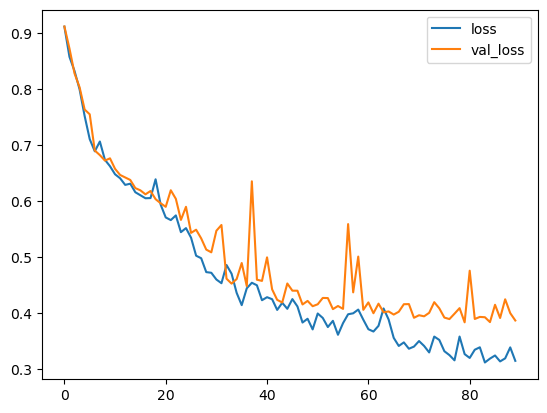

In [16]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

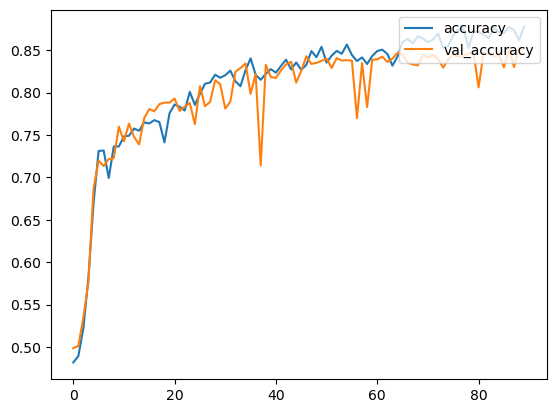

In [17]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [18]:
#Evaluate on the true labels
loss, accuracy = model.evaluate([x_track_test, x_tower_test], true_label_test)

  1/188 [..............................] - ETA: 26s - loss: 1.1106 - accuracy: 0.5938

188/188 [==============================] - 2s 8ms/step - loss: 1.3656 - accuracy: 0.6087


In [19]:
#Evaluate on the training labels
loss, accuracy = model.evaluate([x_track_test, x_tower_test], y_test)
print(accuracy)

 16/188 [=>............................] - ETA: 1s - loss: 0.3572 - accuracy: 0.8477

188/188 [==============================] - 1s 7ms/step - loss: 0.3623 - accuracy: 0.8572
0.8571666479110718


In [20]:
num_classes = 3
x_train_post_model = model.predict([x_track_train[0:1000], x_tower_train[0:1000]])
spec_model = SpectralClustering(n_clusters=num_classes, assign_labels = 'discretize')
spec_results = spec_model.fit_predict(x_train_post_model)
model_clustering =  build_model_clustering(x_train_post_model.shape[1])
one_hot_spec_results = np.eye(num_classes)[spec_results]
history_2 = model_clustering.fit(x_train_post_model, one_hot_spec_results, epochs = 10)


x_predict_pre_kmeans = model.predict([x_track_test, x_tower_test])
x_predict_post_spec = spec_model.fit_predict(x_predict_pre_kmeans)
predicted_labels = np.argmax(true_label_test, axis = 1)

conf_matrix_spec = confusion_matrix(predicted_labels, x_predict_post_spec, labels = [0, 1, 2])
print(conf_matrix_spec)
# Step 2: Use Hungarian algorithm for optimal label assignment
row_ind_spec, col_ind_spec = linear_sum_assignment(-conf_matrix_spec)  # Maximize matches
# Step 3: Map predicted labels to desired labels
label_mapping_spec = {row_spec: col_spec for col_spec, row_spec in zip(row_ind_spec, col_ind_spec)}
final_labels_spec = np.array([label_mapping_spec[label_spec] for label_spec in x_predict_post_spec])

accuracy_spec = np.mean(final_labels_spec == np.argmax(true_label_test, axis = 1))
print(f"Spectral Clustering accuracy on pure data, {accuracy_spec*100:.2f}%")

x_predict_post_ml = np.argmax(model_clustering.predict(x_predict_pre_kmeans), axis = 1)
#Rematching of labels
conf_matrix_ml = confusion_matrix(predicted_labels, x_predict_post_ml, labels = [0, 1, 2])
# Step 2: Use Hungarian algorithm for optimal label assignment
row_ind_ml, col_ind_ml = linear_sum_assignment(-conf_matrix_ml)  # Maximize matches

# Step 3: Map predicted labels to desired labels
label_mapping_ml = {row_ml: col_ml for col_ml, row_ml in zip(row_ind_ml, col_ind_ml)}

# Apply mapping to reorder labels
final_labels_ml = np.array([label_mapping_ml[label_ml] for label_ml in x_predict_post_ml])
accuracy_ml = np.mean(final_labels_ml == np.argmax(true_label_test, axis = 1))
print(f"ML accuracy on pure data, {accuracy_ml*100:.2f}%")


Epoch 1/10
32/32 [==============================] - 0s 3ms/step - loss: 0.7388 - accuracy: 0.6920
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1940 - accuracy: 0.9500
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9820
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0428 - accuracy: 0.9870
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0358 - accuracy: 0.9880
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0306 - accuracy: 0.9910
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0300 - accuracy: 0.9890
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0245 - accuracy: 0.9940
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0242 - accuracy: 0.9920
Epoch 10/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0240 - accuracy: 0.9890
[[ 850   43 1125]
 